## Scaling factor

---

In [1]:
import casadi as ca
import numpy as np
from fabrics.diffGeometry.spec import Spec
from fabrics.diffGeometry.diffMap import DifferentialMap
from fabrics.helpers.variables import Variables

#### 1. Define obstacle

In [2]:
from mpscenes.obstacles.sphere_obstacle import SphereObstacle
circle_dict = {
    'type': 'SphereObstacle',
    'geometry': {
        'position': [1.0, 0.0],
        'radius': 0.5,
    }
}
obstacle = SphereObstacle(name="CircleObstacle", content_dict = circle_dict)

#### 2. Define action and configuration space

In [3]:
x_o = ca.SX.sym('x_o', 1)
xdot_o = ca.SX.sym('xdot_o', 1)

x = ca.SX.sym('x', 2)
xdot = ca.SX.sym('xdot', 2)
variables = Variables(state_variables={'x': x, 'xdot': xdot})

#### 3. Create baseline spec in configuration space

In [4]:
h_b = ca.vcat([x[0]*0, x[1]*0])
lambda_b = 0.01

Le_b = lambda_b / 2 * ca.norm_2(xdot)**2
Me_b = ca.jacobian(ca.jacobian(Le_b, xdot), xdot)

spec_b = Spec(Me_b, h=h_b, x=x, xdot=xdot)
spec_b.concretize()

#### 4. Create collision spec in state space, pulled back to configuration space

\begin{align}
\phi_o &= \left( \frac{||x - x_o||_2}{r_o} - 1 \right)^2 \\
\psi_o &= \frac{1}{\phi_o} \\
h_o &= \dot{x}_o^2 \partial_{x_o}\psi_o
\end{align}

---

\begin{align}
\mathcal{L}_o &= \frac{1}{2} \mathcal{H}(-\dot{x}_o) \frac{1}{x_o} \dot{x}_o^2 \\
M_o &= \partial_{\dot{x}_o, \dot{x}_o}\mathcal{L}_o
\end{align}

---

\begin{align}
f &= M_o h_o \\
\tilde{h}_o &= \\
\tilde{M}_o &= J^T M_o J
\end{align}

In [5]:
phi_o = (ca.norm_2(x - obstacle.position()) / obstacle.radius() - 1)#**2
psi_o = 1 / (x_o)
der_psi_o = ca.jacobian(psi_o, x_o)
h_o = xdot_o**2 * der_psi_o

Le_o = 0.5 * (ca.heaviside(-xdot_o)) * (1/x_o) * xdot_o**2
Me_o = ca.jacobian(ca.jacobian(Le_o, xdot_o), xdot_o)

spec_o = Spec(Me_o, h=h_o, x=x_o, xdot=xdot_o)
spec_o.concretize()

diff_map_o = DifferentialMap(phi_o, variables)
pulled_spec_o = spec_o.pull(diff_map_o)
pulled_spec_o.concretize()

#### 4. Sum together all specs, with `n_obs` number of obstacle specs

In [6]:
def collision_spec_summator(n_obs = 1):
    # Three methods for summation, all similar results
    # 1. Pure by summation of f and M terms
    fe = spec_b.f() + n_obs * pulled_spec_o._f
    Me = spec_b._M + n_obs * pulled_spec_o._M
    
    #fe = n_obs * pulled_spec_o._f
    #Me = n_obs * pulled_spec_o._M
    
    # 2. Summation of h term and Me from d(Le)d(xddot)
    #he = n_obs * pulled_spec_o.h()
    #Le = n_obs * Le_o
    #Me = ca.jacobian(ca.jacobian(Le, xdot), xdot)
    
    # 3. Method 2. + baseline
    #he = spec_b.h() + n_obs * pulled_spec_o.h()
    #Le = Le_b + n_obs * Le_o
    #Me = ca.jacobian(ca.jacobian(Le, xdot), xdot)

    #spec = Spec(Me, h=he, x=x, xdot=xdot)
    spec = Spec(Me, f=fe, x=x, xdot=xdot)
    spec.concretize()
    return spec

n_obs = 5
specs = {}
all_positions = {}
for n_ob in range(n_obs):
    specs[f"spec{n_ob}"] = collision_spec_summator(n_ob + 1)
    all_positions[f"spec{n_ob}"] = 0

In [7]:
n_points = 9
radius = 0.1
radi = 0.4
angles = np.linspace(0, 2*np.pi, n_points, endpoint=False)
xs = 1.0 + radi * np.cos(angles)
ys = radi * np.sin(angles)
obs_positions = np.column_stack((xs, ys))

def spec_n_obstacle_creator(obs_position):
    x_os[f'{obs_position}'] = ca.SX.sym(f'x_o{obs_position}', 1)
    xdot_os[f'{obs_position}'] = ca.SX.sym(f'xdot_o{obs_position}', 1)
    phi_os[f'{obs_position}'] = (ca.norm_2(x - obs_position) / radius - 1)
    psi_os[f'{obs_position}'] = 1 / (x_os[f'{obs_position}'])
    der_psi_os[f'{obs_position}'] = ca.jacobian(psi_os[f'{obs_position}'], x_os[f'{obs_position}'])
    h_os[f'{obs_position}'] = xdot_os[f'{obs_position}']**2 * der_psi_os[f'{obs_position}']
    Le_os[f'{obs_position}'] = 0.5 * (ca.heaviside(-xdot_os[f'{obs_position}'])) * (1/x_os[f'{obs_position}']) * xdot_os[f'{obs_position}']**2
    Me_os[f'{obs_position}'] = ca.jacobian(ca.jacobian(Le_os[f'{obs_position}'], xdot_os[f'{obs_position}']), xdot_os[f'{obs_position}'])
    spec_os[f'{obs_position}'] = Spec(Me_os[f'{obs_position}'], h=h_os[f'{obs_position}'], x=x_os[f'{obs_position}'], xdot=xdot_os[f'{obs_position}'])
    spec_os[f'{obs_position}'].concretize()
    diff_map_os[f'{obs_position}'] = DifferentialMap(phi_os[f'{obs_position}'], variables)
    pulled_spec_os[f'{obs_position}'] = spec_os[f'{obs_position}'].pull(diff_map_os[f'{obs_position}'])
    pulled_spec_os[f'{obs_position}'].concretize()
    
    return pulled_spec_os[f'{obs_position}'].f(), pulled_spec_os[f'{obs_position}']._M

fe_total = spec_b.f(); Me_total = spec_b._M
x_os = {}
xdot_os = {}
phi_os = {}
psi_os = {}
der_psi_os = {}
h_os = {}
Le_os = {}
Me_os = {}
spec_os = {}
diff_map_os = {}
pulled_spec_os = {}

for obs_position in obs_positions:
    fe0, Me0 = spec_n_obstacle_creator(obs_position)
    fe_total += fe0
    Me_total += Me0

specee = Spec(Me_total, f=fe_total, x=x, xdot=xdot)
specee.concretize()

specs['spec5'] = specee
all_positions['spec5'] = 0

n_obs += 1

### Planar simulation of simple collision avoidance spec

Test the spec inside a planar simulation environment.\
The spec produces a trajectory which will be visualized by the environment.

In [8]:
import gym
import numpy as np
import planarenvs.point_robot
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#### 1. Run the simulation to create the trajectory

In [15]:
def spec_simulator(spec):
    env = gym.make("point-robot-acc-v0", render=False, dt=0.01)
    init_pos = np.array([-1.0, 0.3])
    init_vel = np.array([0.5, 0.0])
    ob = env.reset(pos=init_pos, vel=init_vel)
    env.add_obstacle(obstacle)
    n_steps = 1000
    positions = np.zeros((n_steps, 2))
    for i in range(n_steps):
        x = ob['joint_state']['position']
        positions[i] = x
        xdot = ob['joint_state']['velocity']
        M, h, action = spec.evaluate(x=x, xdot=xdot)
        if i == 100:
            print(f"M: {M}")
            print(f"h: {h}")
            print(f"action: {action}")
            print("-----")
        ob, _, _, _ = env.step(action)
    env.close()
    return positions

for spec in specs:
    all_positions[f'{spec}'] = spec_simulator(specs[f'{spec}'])

M: [[ 1.82199996 -0.36110345]
 [-0.36110345  0.08196231]]
h: [ 0.15667379 -0.03122265]
action: [-0.08272272  0.01648535]
-----
M: [[ 3.63367069 -0.72213308]
 [-0.72213308  0.15390827]]
h: [ 0.313008   -0.06237692]
action: [-0.0828594  0.0165124]
-----
M: [[ 5.44534075 -1.08316256]
 [-1.08316256  0.2258542 ]]
h: [ 0.46934166 -0.09353108]
action: [-0.08290504  0.01652144]
-----
M: [[ 7.25701064 -1.44419201]
 [-1.44419201  0.29780012]]
h: [ 0.62567518 -0.12468522]
action: [-0.08292787  0.01652595]
-----
M: [[ 9.06868046 -1.80522144]
 [-1.80522144  0.36974604]]
h: [ 0.78200865 -0.15583934]
action: [-0.08294158  0.01652867]
-----
M: [[ 59.06424462 -12.29200827]
 [-12.29200827   4.84072595]]
h: [ 2.07306118 -0.65313335]
action: [-0.014885   0.0971273]
-----


#### 2. Visualize the trajectory

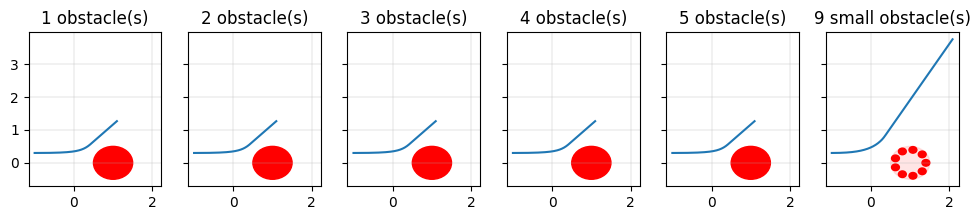

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, n_obs, sharex=True, sharey=True, figsize = (n_obs*2, 1*2))
n = 0
for spec in specs:
    axs[n].plot(all_positions[f'{spec}'][:,0], all_positions[f'{spec}'][:,1])
    axs[n].grid(linestyle='-', linewidth=0.3, alpha=0.8)
    if n == 5:
        axs[n].title.set_text(f'{n_points} small obstacle(s)')
        obsts = {}
        for obs_position in obs_positions:
            obsts[f'{str(obs_position)}'] = plt.Circle(obs_position, radius=radius, color='r')
            axs[n].add_patch(obsts[f'{str(obs_position)}'])
        obst = plt.Circle(obstacle.position(), radius=obstacle.radius(), color='r', alpha=0.1)
        axs[n].add_patch(obst)
    else:
        axs[n].title.set_text(f'{n + 1} obstacle(s)')
        obst = plt.Circle(obstacle.position(), radius=obstacle.radius(), color='r')
        axs[n].add_patch(obst)
    n += 1
plt.legend
plt.show()


In [11]:
for spec in specs:
    print(f" last pos {spec}: {all_positions[f'{spec}'][:,0][-1], all_positions[f'{spec}'][:,1][-1]}")
    

 last pos spec0: (0.3194828212885737, 0.4747387414233504)
 last pos spec1: (0.31892718544460014, 0.47476511374088487)
 last pos spec2: (0.3187414327783815, 0.4747739395855444)
 last pos spec3: (0.31864845465777075, 0.47477835911401095)
 last pos spec4: (0.31859263516182484, 0.4747810129490455)
 last pos spec5: (0.5995827149233507, 1.237614532211734)
